### Task 1 Sentiment ：
Label each employee message with one of three sentiment categories: Positive, Negative, or Neutral.<br>
Output saved in: `sentiment_practice_output.csv`

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

df = pd.read_csv("test.csv")
df = df.dropna(subset=["body"])

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Updated classification function to include Neutral
def classify_sentiment(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"

    # Tokenize input
    inputs = tokenizer(text[:512], return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

    label_id = np.argmax(probs)
    return label_map[label_id]

# Apply classification
tqdm.pandas(desc="Classifying with Neutral")
df["sentiment"] = df["body"].progress_apply(classify_sentiment)

df.to_csv("sentiment_practice_output.csv", index=False)
print("Done.")
print(df["sentiment"].value_counts())


Classifying with Neutral: 100%|██████████| 2191/2191 [02:17<00:00, 15.96it/s]

Done.
sentiment
Neutral     1485
Positive     558
Negative     148
Name: count, dtype: int64


### Task 2 EDA ：<br>
Understand the structure, distribution, and trends in the dataset through thorough exploration

Dataset Overview:
Shape: (2191, 5)

Data Types:
 Subject      object
body         object
date         object
from         object
sentiment    object
dtype: object

Missing Values:
 Subject      0
body         0
date         0
from         0
sentiment    0
dtype: int64


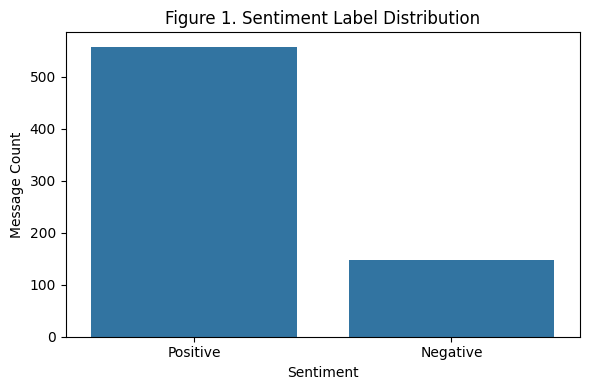

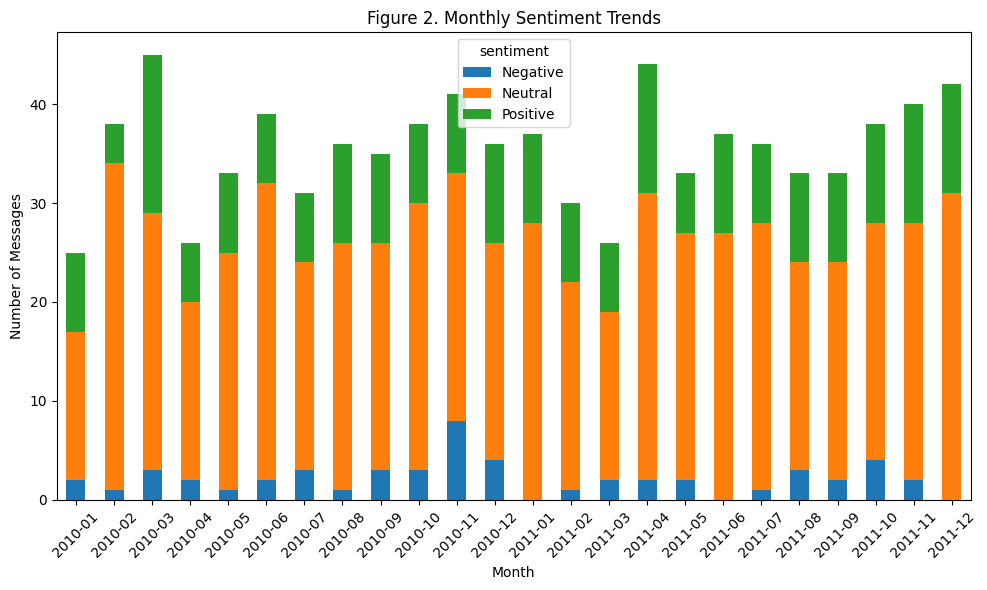

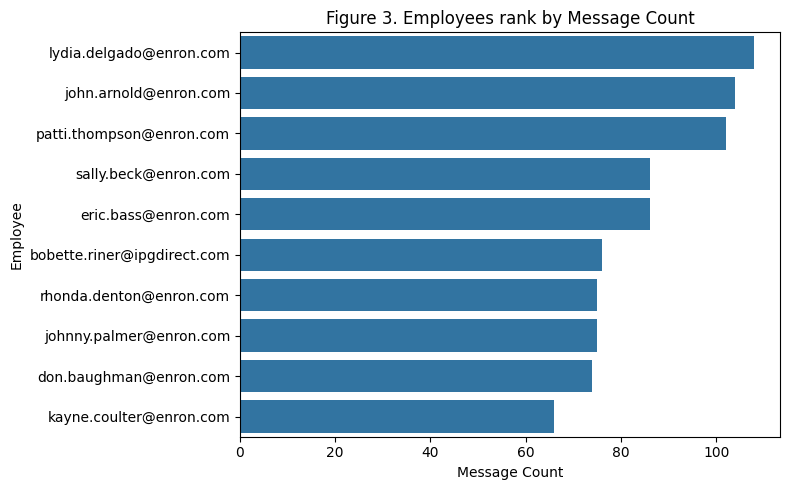

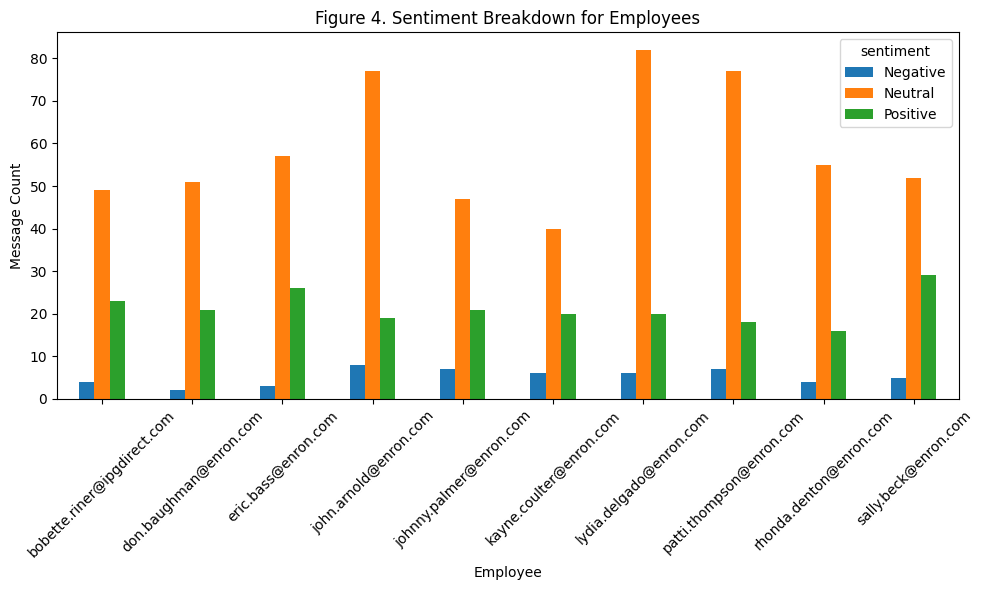

EDA complete.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

output_dir = os.path.join(os.getcwd(), "output")
os.makedirs(output_dir, exist_ok=True)
df = pd.read_csv("sentiment_practice_output.csv")

print("Dataset Overview:")
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

#Sentiment Distribution (Figure 1)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="sentiment", order=["Positive", "Negative"])
plt.title("Figure 1. Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Message Count")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "figure1_sentiment_distribution.png"))
plt.show()

#Monthly Sentiment Trends (Figure 2)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["month"] = df["date"].dt.to_period("M").astype(str)
monthly_sentiment = df.groupby(["month", "sentiment"]).size().unstack(fill_value=0)
monthly_sentiment.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Figure 2. Monthly Sentiment Trends")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "figure2_monthly_sentiment_trends.png"))
plt.show()

#Top 10 Most Active Employees (Figure 3)
top_senders = df["from"].value_counts().head(10)
plt.figure(figsize=(8, 5))
sns.barplot(y=top_senders.index, x=top_senders.values, orient="h")
plt.title("Figure 3. Employees rank by Message Count")
plt.xlabel("Message Count")
plt.ylabel("Employee")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "figure3_employee_rank.png"))
plt.show()

#Sentiment Breakdown for Top 10 Employees (Figure 4)
top10_employees = top_senders.index
df_top = df[df["from"].isin(top10_employees)]
employee_sentiment = df_top.groupby(["from", "sentiment"]).size().unstack(fill_value=0)
employee_sentiment.plot(kind="bar", figsize=(10, 6))
plt.title("Figure 4. Sentiment Breakdown for Employees")
plt.xlabel("Employee")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "figure4_employee_sentiment.png"))
plt.show()

#Summary Statistics Table
summary_stats = {
    "Total Messages": len(df),
    "Unique Employees": df['from'].nunique(),
    "Earliest Message Date": df['date'].min(),
    "Latest Message Date": df['date'].max(),
    "Total Positive Messages": (df['sentiment'] == 'Positive').sum(),
    "Total Negative Messages": (df['sentiment'] == 'Negative').sum()
}
summary_df = pd.DataFrame.from_dict(summary_stats, orient="index", columns=["Value"])
summary_df.to_csv(os.path.join(output_dir, "summary_statistics_table.csv"), encoding="utf-8-sig")

print("EDA complete.")


### Task 3: Employee Score Calculation  
Compute a monthly sentiment score for each employee based on their messages.<br>
There are **10 employees** in total.<br>
Output saved in: `monthly_employee_scores.csv`

In [2]:
import pandas as pd
import os

df = pd.read_csv("sentiment_practice_output.csv")

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])  # Remove rows with invalid dates

#YYYY-MM format
df["month"] = df["date"].dt.to_period("M").astype(str)

sentiment_score_map = {
    "Positive": 1,
    "Negative": -1,
    "Neutral": 0
}
df["score"] = df["sentiment"].map(sentiment_score_map)

#Group by sender and month, then sum the scores
monthly_scores = df.groupby(["from", "month"])["score"].sum().reset_index()

#Rename columns for clarity
monthly_scores.columns = ["employee", "month", "sentiment_score"]

output_path = os.path.join(os.getcwd(), "monthly_employee_scores.csv")
monthly_scores.to_csv(output_path, index=False)
print("Done.")
print(monthly_scores.head())
print(f"\nSaved to: {output_path}")

Done.
                      employee    month  sentiment_score
0  bobette.riner@ipgdirect.com  2010-01                0
1  bobette.riner@ipgdirect.com  2010-02                0
2  bobette.riner@ipgdirect.com  2010-03                1
3  bobette.riner@ipgdirect.com  2010-04                3
4  bobette.riner@ipgdirect.com  2010-05                0

Saved to: c:\Users\Youyou Du\Desktop\1\New Folder\monthly_employee_scores.csv


### Task 4 Employee Ranking:
Generate ranked lists of employees based on their monthly sentiment scores.<br>
Output saved in: `top_positive_employees.csv`;`top_negative_employees.cav`

In [3]:
import pandas as pd

df = pd.read_csv("sentiment_practice_output.csv")
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df["month"] = df["date"].dt.to_period("M").astype(str)
score_map = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["score"] = df["sentiment"].map(score_map)

#Calculate monthly sentiment scores per employee
monthly_scores = (
    df.groupby(["from", "month"])["score"]
    .sum()
    .reset_index()
    .rename(columns={"from": "employee", "score": "monthly_sentiment_score"})
)

#Top 3 Positive employees per month
top_positive = (
    monthly_scores[monthly_scores["monthly_sentiment_score"] > 0]
    .sort_values(by=["month", "monthly_sentiment_score", "employee"], ascending=[True, False, True])
    .groupby("month")
    .head(3)
    .assign(ranking=lambda x: x.groupby("month").cumcount() + 1)
    .reset_index(drop=True)
)

#Top 3 Negative employees per month
top_negative = (
    monthly_scores[monthly_scores["monthly_sentiment_score"] < 0]
    .sort_values(by=["month", "monthly_sentiment_score", "employee"], ascending=[True, True, True])
    .groupby("month")
    .head(3)
    .assign(ranking=lambda x: x.groupby("month").cumcount() + 1)
    .reset_index(drop=True)
)

top_positive.to_csv("top_positive_employees.csv", index=False)
top_negative.to_csv("top_negative_employees.csv", index=False)
print("Done.")


Done.


### Task 5 Flight Risk Identification
Identify employees who are at risk of leaving based on their monthly sentiment scores.<br>

A Flight risk is any employee who has sent **4 or more negative mails** in the span of **30 days**(irrespective of the score).<br>
The 30-day period is rolling count of days, irrepective of months.<br>

C:\Users\Youyou Du\AppData\Local\Temp\ipykernel_11740\95775342.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_df, y="employee", x="negative_msg_count", palette="Reds_r")


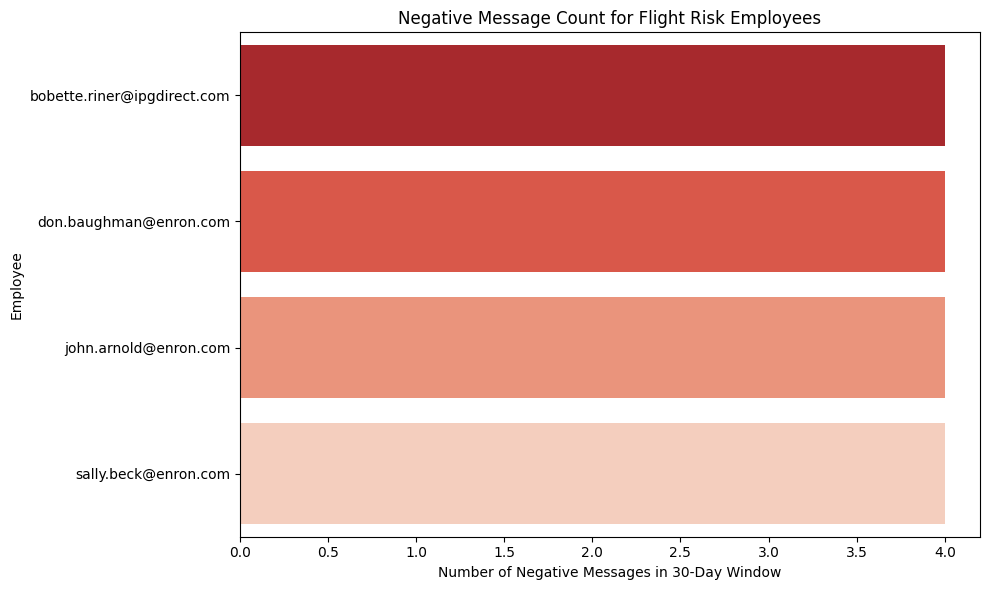

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("sentiment_practice_output.csv")
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# Filter negative messages
negative_df = df[df["sentiment"] == "Negative"].copy()
negative_df = negative_df.sort_values(by=["from", "date"])

# Identify flight risk employees and capture message counts in 30-day window
flight_risk_counts = {}
grouped = negative_df.groupby("from")

for employee, group in grouped:
    group = group.reset_index(drop=True)
    for i in range(len(group)):
        start_date = group.loc[i, "date"]
        window = group[(group["date"] >= start_date) & (group["date"] < start_date + pd.Timedelta(days=30))]
        if len(window) >= 4:
            flight_risk_counts[employee] = len(window)
            break

# Bar chart: negative message count per flagged employee
if flight_risk_counts:
    risk_df = pd.DataFrame({
        "employee": list(flight_risk_counts.keys()),
        "negative_msg_count": list(flight_risk_counts.values())
    }).sort_values(by="negative_msg_count", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=risk_df, y="employee", x="negative_msg_count", palette="Reds_r")
    plt.title("Negative Message Count for Flight Risk Employees")
    plt.xlabel("Number of Negative Messages in 30-Day Window")
    plt.ylabel("Employee")
    plt.tight_layout()
    plt.savefig("flight_risk_negative_msg_count.png")
    plt.show()


### Task 6 Predictive Modeling:
Develop a linear regression model to analyze sentiment trends and predict future sentiment scores.


🔎 Model Evaluation:
RMSE: 0.009647128706547766
R²: 0.9503919583548993
Coefficients: {'lag_1_sentiment': -0.022233825691017717, 'extreme_ratio': 2.674618103484173, 'sentiment_std': -2.8569177350742323, 'message_count': 0.00714951318983692}


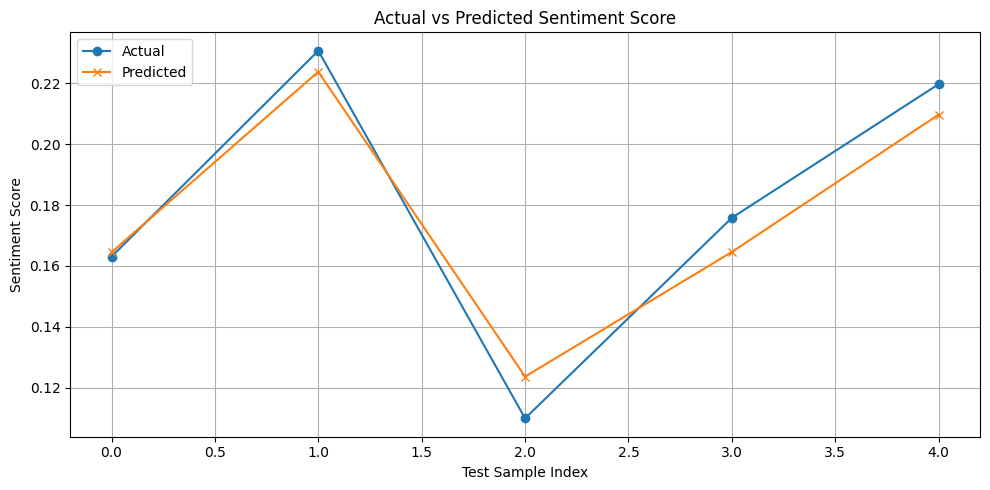

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

df = pd.read_csv("sentiment_practice_output.csv")
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
df.dropna(subset=['date'], inplace=True)
df['sentiment_score'] = df['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Monthly average sentiment
monthly_avg = df.groupby('month')['sentiment_score'].mean().reset_index()
monthly_avg['lag_1_sentiment'] = monthly_avg['sentiment_score'].shift(1)
monthly_avg.dropna(inplace=True)

monthly_sentiment_counts = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)
monthly_sentiment_counts['total'] = monthly_sentiment_counts.sum(axis=1)
monthly_sentiment_counts['positive_ratio'] = monthly_sentiment_counts.get('Positive', 0) / monthly_sentiment_counts['total']
monthly_sentiment_counts['negative_ratio'] = monthly_sentiment_counts.get('Negative', 0) / monthly_sentiment_counts['total']
monthly_sentiment_counts = monthly_sentiment_counts[['positive_ratio', 'negative_ratio']].reset_index()

# Monthly standard deviation
monthly_std = df.groupby('month')['sentiment_score'].std().reset_index(name='sentiment_std')
monthly_msg_count = df.groupby('month').size().reset_index(name='message_count')

# Combine everything together
monthly_df = monthly_avg.merge(monthly_sentiment_counts, on='month')
monthly_df = monthly_df.merge(monthly_std, on='month')
monthly_df = monthly_df.merge(monthly_msg_count, on='month')
monthly_df['extreme_ratio'] = monthly_df['positive_ratio'] + monthly_df['negative_ratio']

# modelling
X = monthly_df[['lag_1_sentiment', 'extreme_ratio', 'sentiment_std', 'message_count']]
y = monthly_df['sentiment_score']

# Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
coefficients = dict(zip(X.columns, model.coef_))

print("\n🔎 Model Evaluation:")
print("RMSE:", rmse)
print("R²:", r2)
print("Coefficients:", coefficients)
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.title("Actual vs Predicted Sentiment Score")
plt.xlabel("Test Sample Index")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
